In [1]:
import os
import pandas as pd

base_dir = 'dataset/flowers-recognition_configed'
input_data_dir = {'test':None, 'train':None, 'validation':None}

totalcounter = 0
dfs = {'train':None, 'validation':None, 'test':None}
for i in input_data_dir:
    print(i)
    classes_names = os.listdir(os.path.join(base_dir, i))
    input_data_dir[i] = os.path.join(base_dir, i)
    classes = {}
    for s in classes_names:
        classes[s] = len(os.listdir(os.path.join(base_dir, i, s)))
        
    inputdata = {'flower':None, 'count':None}
    inputdata['flower'] = [f for f, c in classes.items()]
    inputdata['count'] = [c for f, c in classes.items()]
    
    dfs[i] = pd.DataFrame(inputdata)
    totalcounter += dfs[i]['count'].sum()
    print('\t', 'image count mean:', int(dfs[i]['count'].mean()))
    print('\t', 'image count :', int(dfs[i]['count'].sum()))
print('-'.join(['' for i in range(0, 16)]))
print('total image count:', totalcounter)    

class_count = len(classes)

test
	 image count mean: 183
	 image count : 915
train
	 image count mean: 368
	 image count : 1840
validation
	 image count mean: 181
	 image count : 905
---------------
total image count: 3660


# hyper parameters

In [2]:
from keras import optimizers
import math

h_params = {}

# image
h_params['image_size'] = 150 # defult 150
h_params['batch_size'] = 20 # defult 20

# fit
h_params['epochs'] = 40
h_params['steps_per_epoch'] = math.ceil(dfs['train']['count'].sum()/h_params['batch_size']) # defult 100
h_params['validation_steps'] = math.ceil(dfs['validation']['count'].sum()/h_params['batch_size']) # defult 50

# compile
h_params['learning_rate'] = 1e-3 # defult 2e-5
h_params['optimizer'] = optimizers.RMSprop(lr=h_params['learning_rate'])
h_params['metrics'] = ['acc']

Using TensorFlow backend.


# VGG16

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(h_params['image_size'],
                             h_params['image_size'],
                             3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

# InceptionResNetV2

In [3]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import keras

conv_base = InceptionResNetV2(weights='imagenet',
                include_top=False,
                input_shape=(h_params['image_size'],
                             h_params['image_size'],
                             3))
len(conv_base.layers)

132

# Xception

In [3]:
from keras.applications.xception import Xception
conv_base = Xception(weights='imagenet',
                include_top=False,
                input_shape=(h_params['image_size'],
                             h_params['image_size'],
                             3))
len(conv_base.layers)

132

# ResNet50

In [3]:
from keras.applications.resnet50 import ResNet50
conv_base = ResNet50(weights='imagenet',
                include_top=False,
                input_shape=(h_params['image_size'],
                             h_params['image_size'],
                             3))
len(conv_base.layers)

175

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

#base_dir = '/Users/fchollet/Downloads/cats_and_dogs_small'
train_dir = input_data_dir['train']
validation_dir = input_data_dir['validation']
test_dir = input_data_dir['test']

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(h_params['image_size'],
                                                         h_params['image_size']),
                                            batch_size=batch_size,
                                            class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        #print(labels.shape)
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir,
                                                dfs['train']['count'].sum())
validation_features, validation_labels = extract_features(validation_dir,
                                                          dfs['validation']['count'].sum())
#test_features, test_labels = extract_features(test_dir,
#                                                dfs['test']['count'].sum())


train_features = np.reshape(train_features, (dfs['train']['count'].sum(), 4 * 4 * 512))
validation_features = np.reshape(validation_features, (dfs['validation']['count'].sum(), 4 * 4 * 512))
#test_features = np.reshape(test_features, (dfs['test']['count'].sum(), 4 * 4 * 512))

Found 1840 images belonging to 5 classes.
Found 905 images belonging to 5 classes.


In [5]:
train_labels.shape

(1840, 5)

In [6]:
train_features.shape

(1840, 8192)

In [7]:
from keras import models
from keras import layers
from keras import optimizers
import time

startt = time.time()

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(class_count, activation='softmax'))

model.compile(optimizer=h_params['optimizer'],
                loss='categorical_crossentropy',
                metrics=h_params['metrics'])
history = model.fit(train_features, train_labels,
                    epochs=h_params['epochs'],
                    batch_size=h_params['batch_size'],
                    validation_data=(validation_features, validation_labels))

# save model
import helper as hlp
model_h = {}
model_h['history'] = history
model_h['train_duration'] = round(time.time() - startt)
model_h['hyper_parameters'] = h_params
model_h['hyper_parameters']['optimizer'] = str(h_params['optimizer'])
filename = str(round(time.time()))
filename = '_'.join([filename[:5], filename[5:6], filename[6:7], filename[7:8], filename[8:], 'pretrained_vgg16_extract_feature'])
hlp.save(model_h, 'models/'+filename)

Train on 1840 samples, validate on 905 samples
Epoch 1/40
1840/1840 [==============================] - 1s 533us/step - loss: 1.5727 - acc: 0.2734 - val_loss: 1.3438 - val_acc: 0.5105
Epoch 2/40
1840/1840 [==============================] - 1s 432us/step - loss: 1.3456 - acc: 0.3984 - val_loss: 1.0759 - val_acc: 0.6110
Epoch 3/40
1840/1840 [==============================] - 1s 406us/step - loss: 1.2249 - acc: 0.4641 - val_loss: 0.9920 - val_acc: 0.6917
Epoch 4/40
1840/1840 [==============================] - 1s 402us/step - loss: 1.1197 - acc: 0.5141 - val_loss: 0.8216 - val_acc: 0.7669
Epoch 5/40
1840/1840 [==============================] - 1s 401us/step - loss: 1.0214 - acc: 0.5696 - val_loss: 0.8113 - val_acc: 0.7348
Epoch 6/40
1840/1840 [==============================] - 1s 399us/step - loss: 1.0048 - acc: 0.5592 - val_loss: 0.6994 - val_acc: 0.7624
Epoch 7/40
1840/1840 [==============================] - 1s 416us/step - loss: 0.9958 - acc: 0.5793 - val_loss: 0.6686 - val_acc: 0.7757
E

model file name is: 15781_8_5_3_93_pretrained_vgg16_extract_feature


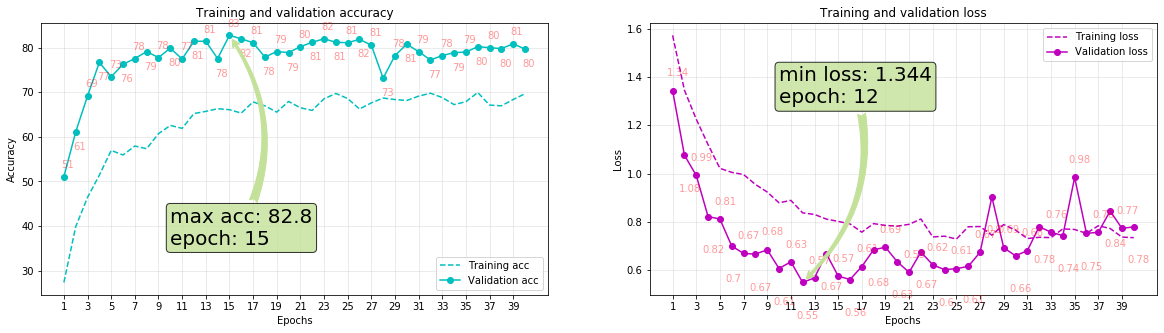

In [9]:
# show result with plot
print('model file name is:', filename)
hlp.show_model_plot(model_h);